# Compute decomposed solution parts

This script evaluates the solution $u^n \in V_h$ by computing its decomposed parts $v^n \in V^{\text{ms}'}_H$ and $w^n \in V^f_h$. First, the settings for the example are defined. 

In [4]:
import numpy as np
import scipy.sparse as sparse
from gridlod import util, fem, coef, interp, linalg
from gridlod.world import World
import lod_wave
import matplotlib.pyplot as plt

'''
Settings
'''

# fine mesh parameters
fine = 1024
NFine = np.array([fine])
NpFine = np.prod(NFine + 1)
boundaryConditions = np.array([[0, 0]])
world = World(np.array([256]), NFine / np.array([256]), boundaryConditions)
NWorldFine = world.NWorldCoarse * world.NCoarseElement

# fine grid elements and nodes
xt = util.tCoordinates(NFine).flatten()
xp = util.pCoordinates(NFine).flatten()

# time step parameters
tau = 0.01
numTimeSteps = 1000

# ms coefficients
epsA = 2 ** (-4)
epsB = 2 ** (-6)
aFine = (2 - np.sin(2 * np.pi * xt / epsA)) ** (-1)
bFine = (2 - np.cos(2 * np.pi * xt / epsB)) ** (-1)

# mesh and localization parameters
k = np.inf
N = 4

# coarse mesh parameters
NWorldCoarse = np.array([N])
NCoarseElement = NFine / NWorldCoarse
world = World(NWorldCoarse, NCoarseElement, boundaryConditions)

# grid nodes
xpCoarse = util.pCoordinates(NWorldCoarse).flatten()
NpCoarse = np.prod(NWorldCoarse + 1)


Plot the multiscale damping coefficient $A_\varepsilon(x) = (2 - \sin(2\pi x/\varepsilon_A))$ with $\varepsilon_A = 2^{-4}$.

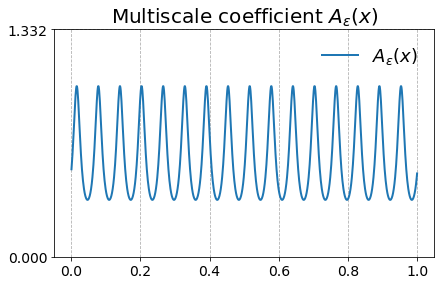

In [2]:
# plot the coefficient
plt.figure('Coefficient')
plt.subplots_adjust(left=0.11, bottom=0.13, right=0.99, top=0.92, wspace=0.1, hspace=0.2)
plt.tick_params(labelsize=14)
plt.plot(xt,aFine, linewidth=2, label='$A_{\epsilon}(x)$')
plt.yticks((0,np.max(aFine)+np.min(aFine)),fontsize=14)
plt.legend(frameon=False,fontsize=18)
plt.title('Multiscale coefficient $A_{\epsilon}(x)$', fontsize=20)
plt.grid(True,which="both",ls="--")
plt.show()


Plot the multiscale propagation coefficient $B_\varepsilon(x) = (2 - \sin(2\pi x/\varepsilon_B))$ with $\varepsilon_B = 2^{-6}$.

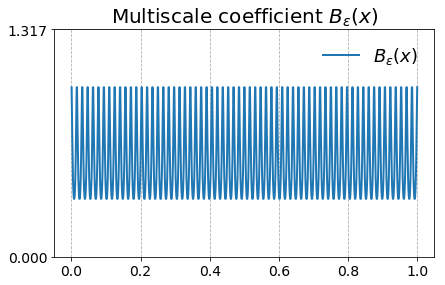

In [3]:
# plot the coefficient
plt.figure('Coefficient')
plt.subplots_adjust(left=0.11, bottom=0.13, right=0.99, top=0.92, wspace=0.1, hspace=0.2)
plt.tick_params(labelsize=14)
plt.plot(xt,bFine, linewidth=2, label='$B_{\epsilon}(x)$')
plt.yticks((0,np.max(bFine)+np.min(bFine)),fontsize=14)
plt.legend(frameon=False,fontsize=18)
plt.title('Multiscale coefficient $B_{\epsilon}(x)$', fontsize=20)
plt.grid(True,which="both",ls="--")
plt.show()


Compute the multiscale basis $\{\lambda_x - \phi_x\}_{x\in \mathcal{N}_H}$, where $\phi_x := \mathcal{Q}\lambda_x \in V^f$ solves

$$a(\phi_x, z) + \tau b(\phi_x, z) = a(\lambda_x, z) + \tau b(\lambda_x, z), \quad \forall z\in V^f$$.

In [5]:
'''
Compute multiscale basis
'''

# patch generator and coefficients
IPatchGenerator = lambda i, N: interp.L2ProjectionPatchMatrix(i, N, NWorldCoarse,
                                                              NCoarseElement, boundaryConditions)
b_coef = coef.coefficientFine(NWorldCoarse, NCoarseElement, bFine)
a_coef = coef.coefficientFine(NWorldCoarse, NCoarseElement, aFine / tau)

# compute basis correctors
lod = lod_wave.LodWave(b_coef, world, k, IPatchGenerator, a_coef)
lod.compute_basis_correctors()

# compute ms basis
basis = fem.assembleProlongationMatrix(NWorldCoarse, NCoarseElement)
basis_correctors = lod.assembleBasisCorrectors()
ms_basis = basis - basis_correctors


Compute the finescale solution corrections $\{w^n_x\}_{x\in \mathcal{N_H}}$, where they solve 

$$ a(w^n_x, z) + \tau b(w^n_x, z) = a(w^{n-1}_x, z), \quad \forall z\in V^f,$$

with $w^0_x = \lambda_x - \phi_x$.

In [6]:
'''
Compute finescale system

fs_solutions[i] = {w^i_x}_x
'''

prev_fs_sol = ms_basis
fs_solutions = []
for i in xrange(numTimeSteps):

    # solve non-localized system
    lod = lod_wave.LodWave(b_coef, world, np.inf, IPatchGenerator, a_coef, prev_fs_sol, ms_basis)
    lod.solve_fs_system()

    # store sparse solution
    prev_fs_sol = sparse.csc_matrix(np.array(np.column_stack(lod.fs_list)))
    fs_solutions.append(prev_fs_sol)


Compute $v^n$ and $w^n$.

In [7]:
'''
Compute v^n and w^n
'''

# initial value
Uo = xpCoarse * (1 - xpCoarse)

# coarse v^(-1) and v^0
V = [Uo]
V.append(Uo)

# fine v^(-1) and v^0
VFine = [ms_basis * Uo]
VFine.append(ms_basis * Uo)

# exact solution
UFine = [ms_basis * Uo]
UFine.append(ms_basis * Uo)

# initial value w^0
Wo = np.zeros(NpFine)
WFine = [Wo]


# compute ms matrices
S = fem.assemblePatchMatrix(NWorldFine, world.ALocFine, aFine)
K = fem.assemblePatchMatrix(NWorldFine, world.ALocFine, bFine)
M = fem.assemblePatchMatrix(NWorldFine, world.MLocFine)

SmsFull = ms_basis.T * S * ms_basis
KmsFull = ms_basis.T * K * ms_basis
MmsFull = ms_basis.T * M * ms_basis

free = util.interiorpIndexMap(NWorldCoarse)

SmsFree = SmsFull[free][:, free]
KmsFree = KmsFull[free][:, free]
MmsFree = MmsFull[free][:, free]

RmsFreeList = []
for i in xrange(numTimeSteps):
    n = i + 1

    # linear system
    A = (1. / tau) * SmsFree + KmsFree
    b = (1. / tau) * SmsFree * V[n][free]

    # store ms matrix R^{ms',h}_{H,i,k}
    RmsFull = ms_basis.T * S * fs_solutions[i]
    RmsFree = RmsFull[free][:, free]
    RmsFreeList.append(RmsFree)

    # add sum to linear system
    if i is not 0:
        for j in range(i):
            b += (1. / tau) * RmsFreeList[j] * V[n - 1 - j][free]

    # solve system
    VFree = linalg.linSolve(A, b)
    VFull = np.zeros(NpCoarse)
    VFull[free] = VFree

    # append solution for current time step
    V.append(VFull)
    VFine.append(ms_basis * VFull)

    # evaluate w^n
    w = 0
    if i is not 0:
        for j in range(0, i + 1):
            w += fs_solutions[j] * V[n - j]
    WFine.append(w)


Compute reference solution $u^n$ on fine mesh.

In [9]:
'''
Compute exact solution
'''

# fine free indices
boundaryMap = boundaryConditions == 0
fixedFine = util.boundarypIndexMap(NWorldFine, boundaryMap)
freeFine = np.setdiff1d(np.arange(NpFine), fixedFine)

SFree = S[freeFine][:, freeFine]
KFree = K[freeFine][:, freeFine]

for i in range(numTimeSteps):
    n = i + 1

    # reference system
    A = (1. / tau) * SFree + KFree
    b = (1. / tau) * SFree * UFine[n][freeFine]

    # solve system
    UFineFree = linalg.linSolve(A, b)
    UFineFull = np.zeros(NpFine)
    UFineFull[freeFine] = UFineFree

    # append solution
    UFine.append(UFineFull)

Print the $L^2$-error between the exact and approximate solutions $\|u^n - v^n - w^n\|_{L^2}$.

In [11]:
# print L2-error
print np.sqrt(np.dot((UFine[-1] - VFine[-1] - WFine[-1]), (UFine[-1] - VFine[-1] - WFine[-1])))

1.3829743714953244e-12
